In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
import json
import matplotlib.dates as mdates
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)
import psycopg2

import matplotlib.ticker as mtick
import matplotlib.dates as mdates

from google.cloud import bigquery
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/daniel.ryu/.config/gcloud/application_default_credentials.json'
bigquery_client = bigquery.Client(project='apprec-prod')

In [4]:
exchange = pd.read_csv('~/Documents/appreciate/exchanges.csv')
imp_type = pd.read_csv('~/Documents/appreciate/imp_type.csv')
buyer = pd.read_csv('~/Documents/appreciate/buyer.csv')

In [5]:
start_dt = '2021-06-16'
end_dt = '2021-06-29'
change_dt = '2021-06-23'

(1) Please could you confirm that the Old Audience is a Subset of the New Audience?

(2) Metrics like BPM, CPM, Impressions, Impressions SOV, Clicks, Clicks SOV, CTR, Installs, Installs SOV, IR, Revenue, Revenue SOV, Ad Format Split, SSP Split etc ….
Broken down by:
* Ignite Users that were in Old Audience and New Audience
* Ignite Users that were ONLY in the New Audience
* Total New Audience

(3) Bundles we bought impressions on before/after making the change

(4) Campaign pacing -> Yaron noticed the campaign is exhausting the budget sooner … please could you help analyze this?
 

# Old audience is subset of new audience

In [6]:
new_aud = bigquery_client.query(f""" 
select string_field_0 as tid
from stats.new_tids
group by 1
    """).to_dataframe()

In [11]:
new_aud['tid_apprec'] = new_aud['tid'].copy()
new_aud

tid_apprec                               tid
0         c96baa7dec736edc9558ff33037aafea  c96baa7dec736edc9558ff33037aafea
1         532ddcfbb7c327658215e19737edce89  532ddcfbb7c327658215e19737edce89
2         089a06619a2ee8ae30d3d171f2f205b6  089a06619a2ee8ae30d3d171f2f205b6
3         bc9645896b50a0310375cb7b9a98affd  bc9645896b50a0310375cb7b9a98affd
4         9d2355bd44f68451af2fbb675adc6eae  9d2355bd44f68451af2fbb675adc6eae
...                                    ...                               ...
82130273  5c84651937935056dd683827a8625fca  5c84651937935056dd683827a8625fca
82130274  8a8b6d42a47b844c3a98272f4602c30b  8a8b6d42a47b844c3a98272f4602c30b
82130275  e05c5f23b0b45dd0768ea778920b89ea  e05c5f23b0b45dd0768ea778920b89ea
82130276  9f9b35341a38bf53f80657ade9023273  9f9b35341a38bf53f80657ade9023273
82130277  6e87405eee299ff871cff544e41c9bc0  6e87405eee299ff871cff544e41c9bc0

[82130278 rows x 2 columns]

In [10]:
old_aud = pd.read_table('files/credit_sesame.txt', header = None, names = ['ifa'])
old_aud

ifa
0         000000f9-ec47-4237-9f06-92b8cd59b423
1         000001f6-f1f5-441f-9418-63f38f934aef
2         000002af-e10f-4fa3-8fd5-997c219819da
3         000002b2-2ab2-4c5d-a7e4-c96cf3868d43
4         000003b9-59b1-41b9-9b2b-b200cb345fa4
...                                        ...
28553583  fffffea6-2380-45b9-9907-e36601dd7bde
28553584  fffffebb-d8fd-4fa6-9f89-13876fa5922f
28553585  fffffed6-ba93-443f-a6a2-541d9492e4e1
28553586  ffffffb4-205d-449f-8bfd-15bce1617436
28553587  ffffffe8-cc28-4dc2-a3a1-b17482557585

[28553588 rows x 1 columns]

In [12]:
filepath = '~/Downloads/credit_sesame_old_aud.csv'
old_aud['ifa'].to_csv(filepath, index = False, header = False)
!ruby ~/Documents/appreciate/ifas_to_tids.rb ~/Downloads/credit_sesame_old_aud.csv ~/Downloads/credit_sesame_old_aud_hashed.txt

In [13]:
hashed_tids = pd.read_table('~/Downloads/credit_sesame_old_aud_hashed.txt', header = None, names = ['tid'])
old_aud = old_aud.join(hashed_tids)
old_aud['tid_dt'] = old_aud['tid']
old_aud.drop('ifa', axis = 1, inplace = True)

old_aud

tid                            tid_dt
0         9688773f094692cb89eb718bc8cda8cf  9688773f094692cb89eb718bc8cda8cf
1         5d6bd8f4cc3a7d1f1b767a3ade59f9fe  5d6bd8f4cc3a7d1f1b767a3ade59f9fe
2         581c070d24047c61d299f44b8d08a34b  581c070d24047c61d299f44b8d08a34b
3         31d713afc5ef971e904c970ab8f85e92  31d713afc5ef971e904c970ab8f85e92
4         dfd21fa202ac81ee8070ac8ef83ecc72  dfd21fa202ac81ee8070ac8ef83ecc72
...                                    ...                               ...
28553583  0610c3d65c601f7aeea8dbbc13d0f8d5  0610c3d65c601f7aeea8dbbc13d0f8d5
28553584  fd152b1a847c787b75a2ee71a6b2193d  fd152b1a847c787b75a2ee71a6b2193d
28553585  e441f54680b7bc905cd09a34f50dff32  e441f54680b7bc905cd09a34f50dff32
28553586  c38a46848da31d3846afead065003f47  c38a46848da31d3846afead065003f47
28553587  d408dce6e8b086b57e4eb20f26da5837  d408dce6e8b086b57e4eb20f26da5837

[28553588 rows x 2 columns]

In [14]:
old_aud_bq = bigquery_client.query(f""" 
select string_field_0 as tid
from stats.tids
group by 1
    """).to_dataframe()
old_aud_bq['tid_dt_bq'] = old_aud_bq['tid']
old_aud_compare = old_aud.set_index('tid').join(old_aud_bq.set_index('tid'), how = 'outer')

In [15]:
print('bq available, file unavailable:',old_aud_compare[(old_aud_compare.tid_dt.isna()) & (~old_aud_compare.tid_dt_bq.isna())].shape)
print('bq unavailable, file available:',old_aud_compare[(~old_aud_compare.tid_dt.isna()) & (old_aud_compare.tid_dt_bq.isna())].shape)
print('bq available, file available:',old_aud_compare[(~old_aud_compare.tid_dt.isna()) & (~old_aud_compare.tid_dt_bq.isna())].shape)


bq available, file unavailable: (8834782, 2)
bq unavailable, file available: (10151697, 2)
bq available, file available: (18401891, 2)


In [16]:
joined_aud = pd.merge(new_aud, old_aud, left_on = 'tid', right_on = 'tid', suffixes = ('_new','_old'), how = 'outer')
joined_aud_bq = pd.merge(new_aud, old_aud_bq, left_on = 'tid', right_on = 'tid', suffixes = ('_new','_old'), how = 'outer')

In [17]:
joined_aud['apprec_aud'] = ~joined_aud.tid_apprec.isna()
joined_aud['dt_aud'] = ~joined_aud.tid_dt.isna()
pivot = joined_aud.pivot_table(values = ['tid_apprec', 'tid_dt'], index = ['apprec_aud','dt_aud'], aggfunc = lambda x:len(x.unique()))
pivot['sov_apprec'] = 100*pivot['tid_apprec']/pivot['tid_apprec'].sum()
pivot['sov_dt'] = 100*pivot['tid_dt']/pivot['tid_dt'].sum()
pivot.style.format({'tid_apprec':'{:,.0f}','tid_dt':'{:,.0f}','sov_apprec':'{:,.0f}%','sov_dt':'{:,.0f}%'})

In [18]:
joined_aud_bq['apprec_aud'] = ~joined_aud_bq.tid_apprec.isna()
joined_aud_bq['dt_aud'] = ~joined_aud_bq.tid_dt_bq.isna()
pivot = joined_aud_bq.pivot_table(values = ['tid_apprec', 'tid_dt_bq'], index = ['apprec_aud','dt_aud'], aggfunc = lambda x:len(x.unique()))
pivot['sov_apprec'] = 100*pivot['tid_apprec']/pivot['tid_apprec'].sum()
pivot['sov_dt'] = 100*pivot['tid_dt_bq']/pivot['tid_dt_bq'].sum()
pivot.style.format({'tid_apprec':'{:,.0f}','tid_dt_bq':'{:,.0f}','sov_apprec':'{:,.0f}%','sov_dt':'{:,.0f}%'})

Adding in verizon BL

In [19]:
!ruby ~/Documents/appreciate/ifas_to_tids.rb files/creditsesame_verizon_bl.txt ~/Downloads/creditsesame_verizon_bl_hashed.txt
verizon_bl = pd.read_table('~/Downloads/creditsesame_verizon_bl_hashed.txt', header = None, names = ['tid'])
verizon_bl['tid_bl'] = verizon_bl['tid']

old_aud_bl_compare = old_aud.set_index('tid').join(verizon_bl.set_index('tid'), how = 'outer')


In [20]:
print('bl available, dt_aud unavailable:',old_aud_bl_compare[(old_aud_bl_compare.tid_dt.isna()) & (~old_aud_bl_compare.tid_bl.isna())].shape[0])
print('bl unavailable, dt_aud available:',old_aud_bl_compare[(~old_aud_bl_compare.tid_dt.isna()) & (old_aud_bl_compare.tid_bl.isna())].shape[0])
print('bl available, dt_aud available:',old_aud_bl_compare[(~old_aud_bl_compare.tid_dt.isna()) & (~old_aud_bl_compare.tid_bl.isna())].shape[0])


bl available, dt_aud unavailable: 24798583
bl unavailable, dt_aud available: 28513857
bl available, dt_aud available: 39731


# Comparison of Audience bidding

In [21]:
df_sub = bigquery_client.query(f"""
    select
        r.tid
        , sp.bundle as sponsored_bnd
        , r.ssb_campaign_uuid
        , c.name as campaign_name
        , ho.bundle as hosting_bnd
        , r.exchange_id
        , r.ad_size
        , r.ad_type
        , r.imp_type
        , r.date
        , r.ctr_model
        , r.cr_model
        , r.no_ifa
        , case when ssb_buyer_id = 3549 then 'DT' else 'other' end as buyer
        , count(case when event_type = 'clear' then 1 else NULL end) as impressions
        , count(case when event_type = 'click' then 1 else NULL end) as clicks
        , count(case when event_type = 'install' then 1 else NULL end) as installs
        , sum(case when event_type = 'install' then revenue else 0 end) as spend
        , sum(case when event_type = 'clear' then settlement_price else 0 end)/1000 as cost
        , sum(case when event_type = 'clear' then bid_price else 0 end)/1000 as bid
    from stats.rows1 r
    join metadata.apps sp
        on r.sponsored_app_id = sp.app_id
    join metadata.apps ho
        on r.hosting_app_id = ho.app_id
    join metadata.dt_campaigns c
        on r.ssb_campaign_uuid = c.uuid
        and c.name = 'Credit Sesame - Credit Sesame - UA – US'
    where 
        date >= '{start_dt}'
        and date <= '{end_dt}'
        and ssb_buyer_id = 3549
    group by 1,2,3,4,5,6,7,8,9,10,11,12,13,14
    """).to_dataframe()
df_sub = df_sub.set_index('exchange_id').join(exchange.set_index('exchange_id')).reset_index()
df_sub = df_sub.set_index('imp_type').join(imp_type.set_index('imp_type_id')).reset_index()

In [22]:
df_sub['date_range'] = df_sub.apply(lambda x: 'post-change' if x.date >= pd.to_datetime(change_dt) else 'pre-change', axis = 1)
df_sub = df_sub.set_index('tid').join(old_aud.set_index('tid'), how = 'left').reset_index()
df_sub = df_sub.set_index('tid').join(new_aud.set_index('tid'), how = 'left').reset_index()
df_sub = df_sub.set_index('tid').join(old_aud_bq.set_index('tid'), how = 'left', rsuffix = '_bq').reset_index()
df_sub['dt_aud'] = ~df_sub['tid_dt'].isna()
df_sub['apprec_aud'] = ~df_sub['tid_apprec'].isna()
df_sub['dt_aud_bq'] = ~df_sub['tid_dt_bq'].isna()
df_sub

tid  index  exchange_id  \
0        0000094f60924416871e91f4362e6a18      1            1   
1        0000094f60924416871e91f4362e6a18      1            1   
2        0000113943ee0ba594bf54f1ced8f05b      1           41   
3        00005cac9ee763834a0134c32ccbcf90      1            1   
4        0000605f6dce746d8898b708ca9a1d08      1           41   
...                                   ...    ...          ...   
1331211  ffffde9cd5da9188140090d30d71c423      1            1   
1331212  ffffdeea72edad7ad182f23cb6665baa      1            3   
1331213  ffffdeea72edad7ad182f23cb6665baa      1            3   
1331214  ffffe2fa6d7e74d59726a47aff193b9d      1            1   
1331215  ffffe2fa6d7e74d59726a47aff193b9d      1            1   

            sponsored_bnd                 ssb_campaign_uuid  \
0        com.creditsesame  d8ee55bb6a1ac49f92211ed4a9313f85   
1        com.creditsesame  d8ee55bb6a1ac49f92211ed4a9313f85   
2        com.creditsesame  d8ee55bb6a1ac49f92211ed4a9313f85   
3        com.creditsesame  d8ee55bb6a1ac49f92211ed4a9313f85   
4        com.creditsesame  d8ee55bb6a1ac49f92211ed4a9313f85   
...                   ...                               ...   
1331211  com.creditsesame  d8ee55bb6a1ac49f92211ed4a9313f85   
1331212  com.creditsesame  d8ee55bb6a1ac49f92211ed4a9313f85   
1331213  com.creditsesame  d8ee55bb6a1ac49f92211ed4a9313f85   
1331214  com.creditsesame  d8ee55bb6a1ac49f92211ed4a9313f85   
1331215  com.creditsesame  d8ee55bb6a1ac49f92211ed4a9313f85   

                                   campaign_name  \
0        Credit Sesame - Credit Sesame - UA – US   
1        Credit Sesame - Credit Sesame - UA – US   
2        Credit Sesame - Credit Sesame - UA – US   
3        Credit Sesame - Credit Sesame - UA – US   
4        Credit Sesame - Credit Sesame - UA – US   
...                                          ...   
1331211  Credit Sesame - Credit Sesame - UA – US   
1331212  Credit Sesame - Credit Sesame - UA – US   
1331213  Credit Sesame - Credit Sesame - UA – US   
1331214  Credit Sesame - Credit Sesame - UA – US   
1331215  Credit Sesame - Credit Sesame - UA – US   

                                 hosting_bnd  ad_size ad_type        date  \
0        com.pixel.art.coloring.color.number   320x50  banner  2021-06-18   
1        com.pixel.art.coloring.color.number   320x50  banner  2021-06-24   
2                      com.playgendary.tanks   320x50  banner  2021-06-17   
3                    com.Garawell.BridgeRace   320x50  banner  2021-06-25   
4                                 wp.wattpad   320x50  banner  2021-06-28   
...                                      ...      ...     ...         ...   
1331211                          mobi.ifunny   320x50  banner  2021-06-27   
1331212                        com.taggedapp   320x50  banner  2021-06-29   
1331213                        com.taggedapp  300x250  banner  2021-06-29   
1331214                          mobi.ifunny   320x50  banner  2021-06-28   
1331215                          mobi.ifunny   320x50  banner  2021-06-27   

         ...       bid exchange_name  impression type   date_range  \
0        ...  0.000242         Fyber          display   pre-change   
1        ...  0.000173         Fyber          display  post-change   
2        ...  0.002062      AppLovin          display   pre-change   
3        ...  0.001754         Fyber          display  post-change   
4        ...  0.003934      AppLovin          display  post-change   
...      ...       ...           ...              ...          ...   
1331211  ...  0.000210         Fyber          display  post-change   
1331212  ...  0.001775         MoPub          display  post-change   
1331213  ...  0.000873         MoPub          display  post-change   
1331214  ...  0.000979         Fyber          display  post-change   
1331215  ...  0.003445         Fyber          display  post-change   

                                   tid_dt                        tid_apprec  \
0        0000094f60924416871e9

In [23]:
def calc_metrics(df, grouping):
    df['ctr'] = 100*df['clicks']/df['impressions']
    df['ir'] = 100*df['installs']/df['clicks']
    df['ipm'] = 1000*df['installs']/df['impressions']
    df['rpi'] = df['spend']/df['installs']
    df['cpm'] = 1000*df['cost']/df['impressions']
    df['bpm'] = 1000*df['bid']/df['impressions']
    df['imp_sov'] = 100*df['impressions']/df['impressions'].groupby(grouping).transform('sum')
    df['spend_sov'] = 100*df['spend']/df['spend'].groupby(grouping).transform('sum')

def display_comparison(df, grouping, asc = False):
    cols = ['impressions','imp_sov','clicks','ctr','installs','ir','ipm','bpm','cpm','rpi','spend','spend_sov','cost']
    format_map = {'impressions':'{:,.0f}'
                 ,'clicks':'{:,.0f}'
                 ,'installs':'{:,.0f}'
                 ,'spend':'${:,.0f}'
                 ,'cost':'${:,.0f}'
                 ,'ctr':'{:,.1f}%'
                 ,'ir':'{:,.0f}%'
                 ,'ipm':'{:,.2f}'
                 ,'cpm':'${:,.2f}'
                 ,'bpm':'${:,.2f}'
                 ,'rpi':'${:,.2f}'
                 ,'imp_sov':'{:,.0f}%'
                 ,'spend_sov':'{:,.0f}%'}
    df.sort_values(grouping + ['spend'], ascending = [asc] * len(grouping) + [False], inplace = True)
    
    return df[cols].style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','bpm','cpm','rpi','imp_sov','spend_sov'])


In [24]:
df_sub.groupby(['date','date_range'])['impressions','clicks','installs','spend','cost'].sum()

<ipython-input-24-9140be8e4528>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_sub.groupby(['date','date_range'])['impressions','clicks','installs','spend','cost'].sum()


impressions  clicks  installs  spend        cost
date       date_range                                                   
2021-06-16 pre-change         98691    1796       125  625.0  398.104051
2021-06-17 pre-change         93221    1655       116  580.0  356.255512
2021-06-18 pre-change        126324    2125       130  650.0  444.558985
2021-06-19 pre-change        122420    2326       116  580.0  482.391829
2021-06-20 pre-change        105385    2096       115  575.0  424.737024
2021-06-21 pre-change        125853    2326       124  620.0  440.622223
2021-06-22 pre-change         80709    2355       130  650.0  401.562902
2021-06-23 post-change       110590    2317       109  545.0  476.657198
2021-06-24 post-change       118640    1994       119  595.0  409.413112
2021-06-25 post-change       128485    2183        98  490.0  455.820237
2021-06-26 post-change       128189    2061       104  520.0  452.452954
2021-06-27 post-change       111966    1886        96  480.0  401.983184
2021-06-28 post-change       142410    2289        95  475.0  480.193647
2021-06-29 post-change       122682    1913        94  470.0  460.587387

In [25]:
i = ['apprec_aud','dt_aud_bq']
filters = (~df_sub.date.isna()) & (df_sub.date_range == 'post-change')
pivot = df_sub[filters].pivot_table(values = ['bid','impressions','clicks','installs','spend','cost'], index = i, aggfunc = np.sum)
calc_metrics(pivot, ['apprec_aud','dt_aud_bq'])
styled_pivot = display_comparison(pivot, ['apprec_aud', 'dt_aud_bq'])
styled_pivot

The drop was with both

In [26]:
i = ['date_range']
filters = (~df_sub.date.isna()) & (df_sub.date_range != '-1')
pivot = df_sub[filters].pivot_table(values = ['bid','impressions','clicks','installs','spend','cost'], index = i, aggfunc = np.sum)
calc_metrics(pivot, ['date_range'])
styled_pivot = display_comparison(pivot, ['date_range'])
styled_pivot

In [27]:
i = ['date_range','apprec_aud','dt_aud_bq']
filters = (~df_sub.date.isna()) & (df_sub.date_range != '-1')
pivot = df_sub[filters].pivot_table(values = ['bid','impressions','clicks','installs','spend','cost'], index = i, aggfunc = np.sum)
calc_metrics(pivot, ['date_range'])
styled_pivot = display_comparison(pivot, ['apprec_aud','dt_aud_bq','date_range'])
styled_pivot

conversion dropped for old audience that was continuously targeted. The new audience that started getting targeted had similarly poor performance

In [28]:
i = ['date_range','ad_type']
filters = (~df_sub.date.isna()) & (df_sub.date_range != '-1')
pivot = df_sub[filters].pivot_table(values = ['bid','impressions','clicks','installs','spend','cost'], index = i, aggfunc = np.sum)
calc_metrics(pivot, ['date_range'])
display_comparison(pivot, ['ad_type','date_range'])

* The banner SOV increased slightly, which would lower overall CTR. 
* IR dropped on banners. 
* BPM increased on all types.

In [29]:
i = ['date_range','ad_type','apprec_aud','dt_aud_bq']
filters = (~df_sub.date.isna()) & (df_sub.date_range != '-1')
pivot = df_sub[filters].pivot_table(values = ['bid','impressions','clicks','installs','spend','cost'], index = i, aggfunc = np.sum)
calc_metrics(pivot, ['date_range'])
display_comparison(pivot, ['ad_type','apprec_aud','dt_aud_bq','date_range'])


* IR dropped even within continuously targeted old_aud, within banners
* Interstitials dropped slightly, new_aud ONLy segment performs worse

In [30]:
i = ['date_range','ad_size']
filters = (~df_sub.date.isna()) & (df_sub.date_range != '-1')
pivot = df_sub[filters].pivot_table(values = ['bid','impressions','clicks','installs','spend','cost'], index = i, aggfunc = np.sum)
calc_metrics(pivot, ['date_range'])
display_comparison(pivot, ['ad_size'])

banner = 320x50 and interstitial = 320x480, as expected

In [31]:
i = ['date_range','impression type']
filters = (~df_sub.date.isna()) & (df_sub.date_range != '-1')
pivot = df_sub[filters].pivot_table(values = ['bid','impressions','clicks','installs','spend','cost'], index = i, aggfunc = np.sum)
calc_metrics(pivot, ['date_range','impression type'])
styled_pivot = display_comparison(pivot, ['date_range'])
styled_pivot

In [32]:
i = ['date_range','ctr_model']
filters = (~df_sub.date.isna()) & (df_sub.date_range != '-1')
pivot = df_sub[filters].pivot_table(values = ['bid','impressions','clicks','installs','spend','cost'], index = i, aggfunc = np.sum)
calc_metrics(pivot, ['date_range'])
display_comparison(pivot, ['ctr_model','date_range'])

Larger CTR & IPM drops (~50%) on certain models (could be noise):
- a94fa2ff18124266653428e724fc1faa_v2c	
- 98982db740dd1b9307fe4f694b2f5953_v2c
- bd4012dba254aa017089e6adbe31090f_v2c	

In [33]:
i = ['date_range','cr_model']
filters = (~df_sub.date.isna()) & (df_sub.date_range != '-1')
pivot = df_sub[filters].pivot_table(values = ['bid','impressions','clicks','installs','spend','cost'], index = i, aggfunc = np.sum)
calc_metrics(pivot, ['date_range'])
display_comparison(pivot, ['cr_model','date_range'])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/io/formats/style.py:1268: RuntimeWarning: invalid value encountered in double_scalars
  norm = colors.Normalize(smin - (rng * low), smax + (rng * high))


In [34]:
i = ['date_range','no_ifa']
filters = (~df_sub.date.isna()) & (df_sub.date_range != '-1')
pivot = df_sub[filters].pivot_table(values = ['bid','impressions','clicks','installs','spend','cost'], index = i, aggfunc = np.sum)
calc_metrics(pivot, ['date_range'])
display_comparison(pivot, ['date_range'])

In [35]:
i = ['date_range','exchange_name']
filters = (~df_sub.date.isna()) & (df_sub.date_range != '-1')
pivot = df_sub[filters].pivot_table(values = ['bid','impressions','clicks','installs','spend','cost'], index = i, aggfunc = np.sum)
calc_metrics(pivot, ['date_range'])
display_comparison(pivot, ['exchange_name'])

* Fyber is the non-first price exchange that makes the bpm $\neq$ cpm
* Seeing largest drops on Fyber and AppLovin

In [36]:
i = ['date_range','exchange_name','apprec_aud','dt_aud_bq']
filters = (df_sub.exchange_name.isin(['Fyber','AppLovin'])) & (df_sub.date_range != '-1')
pivot = df_sub[filters].pivot_table(values = ['bid','impressions','clicks','installs','spend','cost'], index = i, aggfunc = np.sum)
calc_metrics(pivot, ['date_range'])
display_comparison(pivot, ['exchange_name','apprec_aud','dt_aud_bq','date_range'])

* Drop on Fyber is larger than that on AppLovin

In [37]:
i = ['date_range','exchange_name','ad_type','apprec_aud','dt_aud_bq']
filters = (df_sub.exchange_name.isin(['Fyber','AppLovin'])) & (df_sub.date_range != '-1')
pivot = df_sub[filters].pivot_table(values = ['bid','impressions','clicks','installs','spend','cost'], index = i, aggfunc = np.sum)
calc_metrics(pivot, ['date_range'])
display_comparison(pivot, ['exchange_name','ad_type','apprec_aud','dt_aud_bq','date_range'])

In [38]:
df_sub[(df_sub.spend > 0) & (df_sub.date_range != '-1')].groupby('hosting_bnd')['spend'].sum().sort_values(ascending = False)

hosting_bnd
com.pinger.textfree                    350.0
com.grindrapp.android                  270.0
slots.pcg.casino.games.free.android    245.0
com.scannerradio                       240.0
com.player.ootvo                       230.0
                                       ...  
com.onebutton.mrsuper                    5.0
com.oneway.Deathcoming                   5.0
com.orbitalknight.castlewreck            5.0
com.os.falcon.among.impostor.z           5.0
and.lihuhu.mahjong3d                     5.0
Name: spend, Length: 359, dtype: float64

In [46]:
top_pubs = df_sub[(df_sub.spend > 0) & (df_sub.date_range != '-1')].groupby('hosting_bnd')['cost'].sum().sort_values(ascending = False).index[:20]
i = ['date_range','hosting_bnd']
filters = (df_sub.hosting_bnd.isin(top_pubs)) & (df_sub.date_range != '-1')
pivot = df_sub[filters].pivot_table(values = ['bid','impressions','clicks','installs','spend','cost'], index = i, aggfunc = np.sum)
calc_metrics(pivot, ['date_range'])
display_comparison(pivot, ['hosting_bnd','date_range'])

In [52]:
i = ['hosting_bnd','date']

filters = (df_sub.hosting_bnd.isin(['com.pinger.textfree','com.grindrapp.android','com.enflick.android.TextNow'])) & (df_sub.date_range != '-1')
pivot = df_sub[filters].pivot_table(values = ['bid','impressions','clicks','installs','spend','cost'], index = i, aggfunc = np.sum)
calc_metrics(pivot, ['date'])
display_comparison(pivot, ['hosting_bnd','date'])

In [40]:
df_sub[df_sub.date_range != '-1'].pivot_table(values = 'hosting_bnd', index = 'date', aggfunc = lambda x:len(x.unique()))

hosting_bnd
date                   
2021-06-16         1024
2021-06-17          967
2021-06-18         1084
2021-06-19         1200
2021-06-20         1148
2021-06-21         1159
2021-06-22         1116
2021-06-23         1212
2021-06-24         1219
2021-06-25         1157
2021-06-26         1134
2021-06-27         1094
2021-06-28         1081
2021-06-29         1114

sp.bundle as sponsored_bnd
        , r.ssb_campaign_uuid
        , c.name as campaign_name
        , ho.bundle as hosting_bnd
        , r.exchange_id
        , r.ad_size
        , r.ad_type
        , r.imp_type
        , r.date
        , r.ctr_model
        , r.no_ifa

In [58]:
df_organic = bigquery_client.query(f"""
    select
        edate
        , count(distinct ifa) as installs
    from `ext_data.RTB202106*`
    where etype = 'install'
    and bundle = 'com.creditsesame'
    group by 1
    """).to_dataframe()

In [59]:
df_organic.sort_values('edate')


edate  installs
14  2021-06-01       107
3   2021-06-02       100
20  2021-06-03       109
9   2021-06-04       126
13  2021-06-05       124
8   2021-06-06       137
17  2021-06-07       126
21  2021-06-08        57
11  2021-06-09       130
10  2021-06-10       117
4   2021-06-11       117
6   2021-06-12       115
2   2021-06-13       132
12  2021-06-14       118
19  2021-06-15       139
18  2021-06-16       133
7   2021-06-17       135
1   2021-06-18       116
5   2021-06-19       123
0   2021-06-20       118
15  2021-06-21       128
16  2021-06-22       134

# Campaign Pacing

In [63]:
df_pacing = bigquery_client.query(f"""
    select
        r.date
        , extract(hour from r.timestamp) as hour
        , count(case when event_type = 'clear' then 1 else NULL end) as impressions
        , count(case when event_type = 'click' then 1 else NULL end) as clicks
        , count(case when event_type = 'install' then 1 else NULL end) as installs
        , sum(case when event_type = 'install' then revenue else 0 end) as spend
        , sum(case when event_type = 'clear' then settlement_price else 0 end)/1000 as cost
        , sum(case when event_type = 'clear' then bid_price else 0 end)/1000 as bid
    from stats.rows r
    join metadata.dt_campaigns c
        on r.ssb_campaign_uuid = c.uuid
        and lower(c.name) like '%credit sesame%'
    where 
        date >= '{start_dt}'
        and date <= '2021-05-24'
        and ssb_buyer_id = 3549
    group by 1,2
    
    union all
    
    select
        r.date
        , extract(hour from r.timestamp) as hour
        , count(case when event_type = 'clear' then 1 else NULL end) as impressions
        , count(case when event_type = 'click' then 1 else NULL end) as clicks
        , count(case when event_type = 'install' then 1 else NULL end) as installs
        , sum(case when event_type = 'install' then revenue else 0 end) as spend
        , sum(case when event_type = 'clear' then settlement_price else 0 end)/1000 as cost
        , sum(case when event_type = 'clear' then bid_price else 0 end)/1000 as bid
    from stats.rows1 r
    join metadata.dt_campaigns c
        on r.ssb_campaign_uuid = c.uuid
        and lower(c.name) like '%credit sesame%'
    where 
        date >= '2021-05-25'
        and date <= '{end_dt}'
        and ssb_buyer_id = 3549
    group by 1,2
    """).to_dataframe()

In [64]:
df_pacing['cap_hour'] = df_pacing[df_pacing.impressions > 0].groupby('date')['hour'].transform('max')

Text(0.5, 1.0, 'installs by day for Credit Sesame')

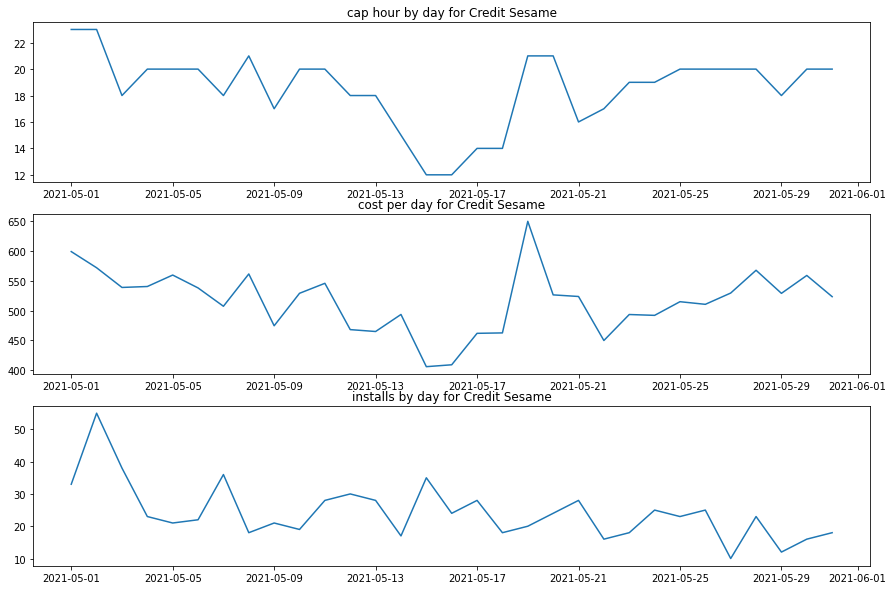

In [65]:
fig, ax = plt.subplots(3,1,figsize = (15,10))
ax[0].plot(df_pacing.groupby('date')['cap_hour'].max())
ax[0].set_title('cap hour by day for Credit Sesame')
ax[1].plot(df_pacing.groupby('date')['cost'].sum())
ax[1].set_title('cost per day for Credit Sesame')
ax[2].plot(df_pacing.groupby('date')['installs'].max())
ax[2].set_title('installs by day for Credit Sesame')

# organic install data

In [71]:
df_organic_compare = bigquery_client.query(f"""
select
    event_date 
    , t1.installs_rows1
    , t2.installs_extdata
from
(
    select 
        date(etimestamp) as event_date
        , count(case when event_type = 'install' then 1 else NULL end) as `installs_rows1`
    from stats.rows1 r
    join metadata.dt_campaigns c
        on r.ssb_campaign_uuid = c.uuid
        and lower(c.name) like '%credit sesame%'
    where 
        date >= '{start_dt}'
    group by 1
) t1
left join
(
    select  
        edate
        , count(*) as installs_extdata 
    from `ext_data.RTB202105*`
    where 
        bundle = 'com.creditsesame'
        and etype = 'install'
    group by 1
union all
    select  
        edate
        , count(*) as installs_extdata
    from `ext_data.RTB202106*`
    where 
        bundle = 'com.creditsesame'
        and etype = 'install'
    group by 1
) t2
    on t1.event_date = date(t2.edate)
group by 1,2,3
order by 1
    """).to_dataframe()

<AxesSubplot:xlabel='event_date'>

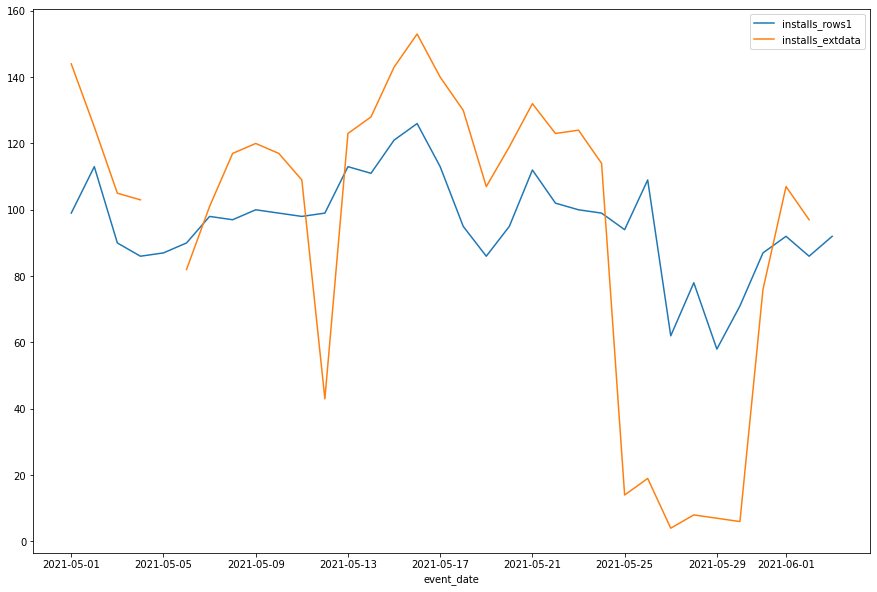

In [77]:
# df_organic_compare.set_index('event_date', inplace = True)
df_organic_compare.plot(figsize = (15,10))